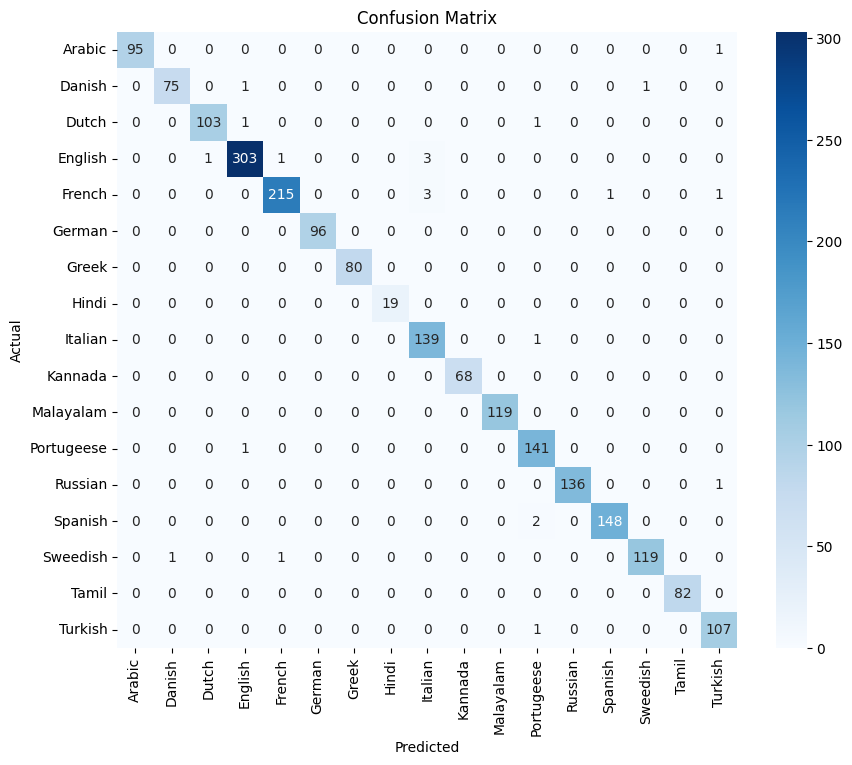

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
import tkinter as tk
from tkinter import messagebox, ttk
from googletrans import Translator

# Load and preprocess data
ld = pd.read_csv("Language/Language Detection.csv")

def remove_punctuation(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

ld['Text'] = ld["Text"].apply(remove_punctuation)

X = ld.iloc[:, 0]
y = ld.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

vec = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer="char")

model = pipeline.Pipeline([("vec", vec), ('clf', linear_model.LogisticRegression())])

model.fit(X_train, y_train)

predict = model.predict(X_test)

accuracy = accuracy_score(y_test, predict) * 100
con_matrix = confusion_matrix(y_test, predict)

# Initialize the translator
translator = Translator()

# Create Tkinter UI
class LanguageDetectionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Language Detection and Translation")

        self.label = tk.Label(root, text="Enter text for detection and translation:")
        self.label.pack()

        self.text_entry = tk.Entry(root, width=100)
        self.text_entry.pack()

        self.detect_button = tk.Button(root, text="Detect Language", command=self.detect_language)
        self.detect_button.pack()

        self.language_label = tk.Label(root, text="")
        self.language_label.pack()

        self.translate_to_label = tk.Label(root, text="Translate to:")
        self.translate_to_label.pack()

        self.language_options = ttk.Combobox(root, values=["English", "French", "Hindi", "Spanish"])
        self.language_options.set("English")
        self.language_options.pack()

        self.translate_button = tk.Button(root, text="Translate", command=self.translate_text)
        self.translate_button.pack()

        self.translated_text_entry = tk.Entry(root, width=100)
        self.translated_text_entry.pack()

        self.accuracy_label = tk.Label(root, text=f"Model Accuracy: {accuracy:.2f}%")
        self.accuracy_label.pack()

        self.show_confusion_matrix_button = tk.Button(root, text="Show Confusion Matrix", command=self.show_confusion_matrix)
        self.show_confusion_matrix_button.pack()

    def detect_language(self):
        input_text = self.text_entry.get()
        if not input_text:
            messagebox.showwarning("Input Error", "Please enter some text to detect the language.")
            return
        
        prediction = model.predict([input_text])
        self.language_label.config(text=f"Detected Language: {prediction[0]}")

    def translate_text(self):
        input_text = self.text_entry.get()
        if not input_text:
            messagebox.showwarning("Input Error", "Please enter some text to translate.")
            return

        target_language = self.language_options.get().lower()
        language_map = {"english": "en", "french": "fr", "hindi": "hi", "spanish": "es"}

        detected_language = translator.detect(input_text).lang
        self.language_label.config(text=f"Detected Language: {detected_language}")

        if target_language in language_map:
            translated_text = translator.translate(input_text, src=detected_language, dest=language_map[target_language])
            self.translated_text_entry.delete(0, tk.END)  # Clear the entry field
            self.translated_text_entry.insert(0, translated_text.text)  # Insert the translated text
        else:
            self.translated_text_entry.delete(0, tk.END)
            self.translated_text_entry.insert(0, "Invalid target language selected.")

    def show_confusion_matrix(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

if __name__ == "__main__":
    root = tk.Tk()
    app = LanguageDetectionApp(root)
    root.mainloop()